In [1]:
import requests
import datetime
import pandas as pd

# Define the endpoint and parameters
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    "vs_currency": "inr",
    "days": "365"
}

# Make the request to the CoinGecko API
response = requests.get(url, params=params)
data = response.json()

# Extract the prices, volumes, and market caps
prices = data['prices']
volumes = data['total_volumes']
market_caps = data['market_caps']

# Prepare the data
data_list = []
for i in range(len(prices)):
    timestamp = prices[i][0] / 1000  # Convert milliseconds to seconds
    date = datetime.datetime.fromtimestamp(timestamp).date()
    price_inr = prices[i][1]
    volume = volumes[i][1]
    market_cap = market_caps[i][1]
    data_list.append([date, price_inr, volume, market_cap])

# Create a DataFrame
df = pd.DataFrame(data_list, columns=['Date', 'Price', 'Volume', 'Market Cap'])
# Ensure Date is the index
df.set_index('Date', inplace=True)
print(df)

                   Price        Volume    Market Cap
Date                                                
2023-07-26  2.394833e+06  6.498536e+11  4.654999e+13
2023-07-27  2.407109e+06  1.072954e+12  4.676977e+13
2023-07-28  2.405374e+06  7.453014e+11  4.676509e+13
2023-07-29  2.411567e+06  6.320330e+11  4.688794e+13
2023-07-30  2.415075e+06  4.016689e+11  4.695809e+13
...                  ...           ...           ...
2024-07-20  5.583949e+06  3.097577e+12  1.102017e+14
2024-07-21  5.627197e+06  1.453009e+12  1.109981e+14
2024-07-22  5.701057e+06  2.267320e+12  1.124791e+14
2024-07-23  5.656839e+06  3.611061e+12  1.115510e+14
2024-07-24  5.512408e+06  3.067064e+12  1.087634e+14

[365 rows x 3 columns]


In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Prepare the dataset for the model
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), :]
        X.append(a)
        Y.append(data[i + time_step, 0])  # Predicting the price
    return np.array(X), np.array(Y)

# Create the dataset
time_step = 30  # Last 30 days
X, Y = create_dataset(scaled_data, time_step)

# Split the data into training and testing sets
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Create the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=10)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0360
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0046
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0039
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0025
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0018
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


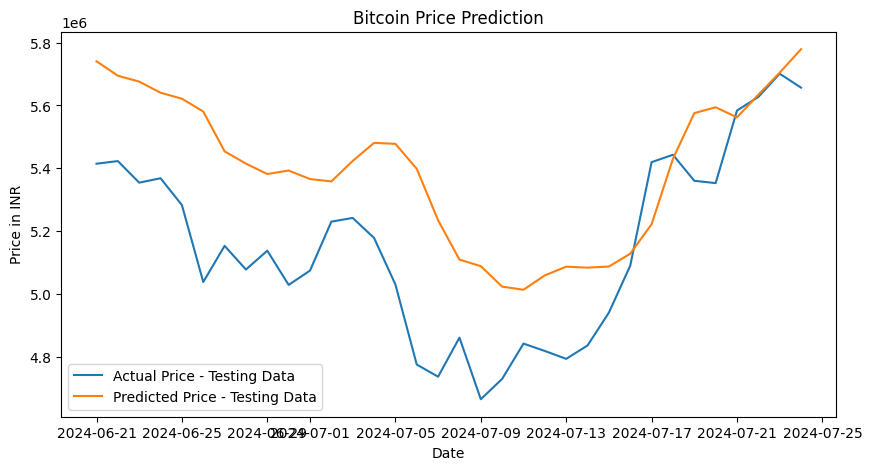

In [4]:
# Evaluate the model
# train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
# train_predict = scaler.inverse_transform(np.concatenate((train_predict, X_train[:, -1, 1:]), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, X_test[:, -1, 1:]), axis=1))[:, 0]

# Get the actual values
# Y_train_actual = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]
Y_test_actual = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
# plt.plot(df.index[-len(Y_train_actual):], Y_train_actual, label='Actual Price - Training Data')
plt.plot(df.index[-len(Y_test_actual):], Y_test_actual, label='Actual Price - Testing Data')
# plt.plot(df.index[-len(Y_train_actual):], train_predict, label='Predicted Price - Training Data')
plt.plot(df.index[-len(Y_test_actual):], test_predict, label='Predicted Price - Testing Data')
plt.xlabel('Date')
plt.ylabel('Price in INR')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()


In [5]:
print(test_predict)

[5740833.78298019 5694721.72568538 5676030.36610053 5640637.92182738
 5621551.91429585 5580809.24579115 5453920.23035526 5414805.36633086
 5381654.93880994 5392845.85801252 5365626.97966618 5358113.05311307
 5423389.90556905 5480882.16165717 5477791.22594051 5398402.87019694
 5234303.38001891 5109127.81807813 5088241.28843975 5023101.66368705
 5013125.446258   5058981.26630685 5086621.05514308 5083551.17678089
 5087061.36679102 5127946.70478724 5221897.04924434 5430115.71922625
 5575668.17550736 5594172.14829739 5562179.63867277 5634323.79128002
 5704488.3159677  5779143.97214449]


In [6]:
print(Y_test_actual)

[5414532.84569665 5422917.84284775 5354170.9760731  5368233.295187
 5282950.41854981 5037773.73743603 5152823.06610879 5077522.43306742
 5137474.28820687 5028494.62999895 5074125.59496904 5230025.51294678
 5241840.50690638 5178168.70601478 5029915.63131174 4774933.63156478
 4736204.01687039 4860629.53094265 4664466.25165632 4729145.26238323
 4841632.15416352 4818078.72957386 4792989.92845482 4835646.47938435
 4940330.75708209 5089935.9388717  5419458.34763521 5442992.53660742
 5360092.44096616 5352731.55858906 5583949.26641378 5627197.4008782
 5701056.72671812 5656838.79168023]


In [7]:
price_diff = test_predict[-1]-Y_test_actual[-1]
print(price_diff)

122305.18046425749


[ 6.02639132  5.01213352  6.01137677  5.0743813   6.40932564 10.77927546
  5.84334374  6.64266752  4.75293183  7.24573167  5.74485947  2.4490806
  3.46346667  5.84595584  8.90423672 13.05712889 10.5168477   5.11247125
  9.08517747  6.21584631  3.54205538  4.99997095  6.12626213  5.1266092
  2.9700564   0.7467828   3.64540671  0.23657606  4.02186598  4.51060523
  0.38986077  0.12664191  0.06019216  2.16207647]


Text(0.5, 0, 'No. of Day')

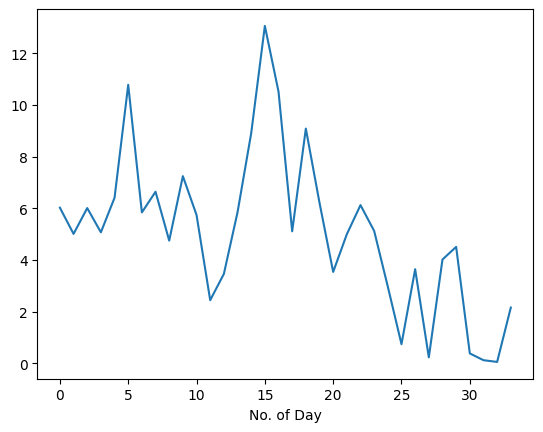

In [8]:
price_diff = []  # Initialize the list outside of the loop

for i in range(0, 34):
    diff = 100*(test_predict[i] - Y_test_actual[i])/Y_test_actual[i] #Calculate the percentage
    price_diff.append(diff)  # Append the difference to the list

# Convert the list to a 1D NumPy array
price_diff_array = abs(np.array(price_diff))
print(price_diff_array)
plt.plot(price_diff_array)
plt.xlabel('No. of Day')

In [9]:
price_diff_array.min()

0.060192161104046245

In [10]:
price_diff_array.max()

13.057128888885535

In [11]:
X_test

array([[[0.97396849, 0.37186503, 0.9766792 ],
        [0.94806384, 0.42614973, 0.95126561],
        [0.92620135, 0.32081606, 0.92946527],
        ...,
        [0.87700305, 0.12859882, 0.8824997 ],
        [0.87313115, 0.30443684, 0.87678053],
        [0.84231376, 0.42938228, 0.84586593]],

       [[0.94806384, 0.42614973, 0.95126561],
        [0.92620135, 0.32081606, 0.92946527],
        [0.89963498, 0.40643246, 0.90195841],
        ...,
        [0.87313115, 0.30443684, 0.87678053],
        [0.84231376, 0.42938228, 0.84586593],
        [0.83887906, 0.22305722, 0.84287119]],

       [[0.92620135, 0.32081606, 0.92946527],
        [0.89963498, 0.40643246, 0.90195841],
        [0.90899077, 0.28936295, 0.91335114],
        ...,
        [0.84231376, 0.42938228, 0.84586593],
        [0.83887906, 0.22305722, 0.84287119],
        [0.84099143, 0.26903815, 0.84694796]],

       ...,

       [[0.84099143, 0.26903815, 0.84694796],
        [0.82367257, 0.25510128, 0.82878229],
        [0.82721518, 0

In [12]:
Y_test

array([0.83887906, 0.84099143, 0.82367257, 0.82721518, 0.80573054,
       0.74396511, 0.77294858, 0.75397868, 0.76908188, 0.74162749,
       0.75312294, 0.79239758, 0.79537404, 0.7793337 , 0.74198548,
       0.67774987, 0.66799302, 0.69933856, 0.64992069, 0.66621477,
       0.6945527 , 0.68861907, 0.68229865, 0.69304478, 0.71941706,
       0.75710592, 0.8401199 , 0.84604869, 0.82516432, 0.82330995,
       0.8815588 , 0.89245397, 0.91106076, 0.89992129])

In [13]:
X

array([[[0.07814988, 0.07744079, 0.07580237],
        [0.08124248, 0.13061072, 0.07860654],
        [0.08080546, 0.08943547, 0.07854679],
        ...,
        [0.0217232 , 0.09372308, 0.02109959],
        [0.0197103 , 0.1388389 , 0.01871333],
        [0.02486241, 0.14722972, 0.0242158 ]],

       [[0.08124248, 0.13061072, 0.07860654],
        [0.08080546, 0.08943547, 0.07854679],
        [0.08236547, 0.07520132, 0.08011426],
        ...,
        [0.0197103 , 0.1388389 , 0.01871333],
        [0.02486241, 0.14722972, 0.0242158 ],
        [0.01894381, 0.11999693, 0.01842136]],

       [[0.08080546, 0.08943547, 0.07854679],
        [0.08236547, 0.07520132, 0.08011426],
        [0.08324939, 0.04625209, 0.0810094 ],
        ...,
        [0.02486241, 0.14722972, 0.0242158 ],
        [0.01894381, 0.11999693, 0.01842136],
        [0.01644326, 0.02256233, 0.01586772]],

       ...,

       [[0.84099143, 0.26903815, 0.84694796],
        [0.82367257, 0.25510128, 0.82878229],
        [0.82721518, 0

In [14]:
last_sequence = scaled_data[-time_step:]
def predict_future(model, data, days_ahead, time_step):
    temp_input = data[-time_step:].reshape(1, time_step, data.shape[1])
    predictions = []
    for _ in range(days_ahead):
        prediction = model.predict(temp_input)
        predictions.append(prediction[0, 0])
        temp_input = np.append(temp_input[:, 1:, :], [[np.append(prediction, temp_input[:, -1, 1:])]], axis=1)
    return predictions


In [15]:
# Predict the next day, week, and month
next_day_prediction = predict_future(model, scaled_data, 1, time_step)
next_week_prediction = predict_future(model, scaled_data, 7, time_step)
next_month_prediction = predict_future(model, scaled_data, 30, time_step)

# Inverse transform to get actual values
next_day_price = scaler.inverse_transform(np.concatenate((np.array(next_day_prediction).reshape(-1, 1), np.zeros((1, 2))), axis=1))[:, 0]
next_week_price = scaler.inverse_transform(np.concatenate((np.array(next_week_prediction).reshape(-1, 1), np.zeros((7, 2))), axis=1))[:, 0]
next_month_price = scaler.inverse_transform(np.concatenate((np.array(next_month_prediction).reshape(-1, 1), np.zeros((30, 2))), axis=1))[:, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [16]:
next_day_price

array([5732065.87913847])

/var/folders/yh/b3ltzp290w726xvdx_kqxdr00000gn/T/ipykernel_14095/635397982.py:3: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(dates, week, 'g')


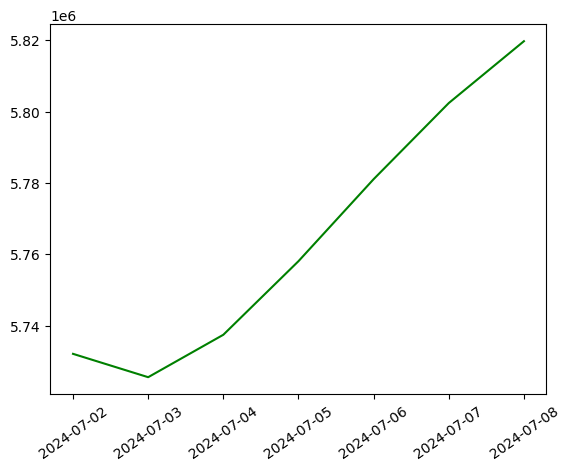

In [17]:
week = next_week_price
dates = pd.date_range(start='7/2/2024',periods=7)
plt.plot_date(dates, week, 'g')
plt.xticks(rotation=35)
plt.show()

/var/folders/yh/b3ltzp290w726xvdx_kqxdr00000gn/T/ipykernel_14095/3716881554.py:3: MatplotlibDeprecationWarning: The plot_date function was deprecated in Matplotlib 3.9 and will be removed in 3.11. Use plot instead.
  plt.plot_date(dates, month, 'g')


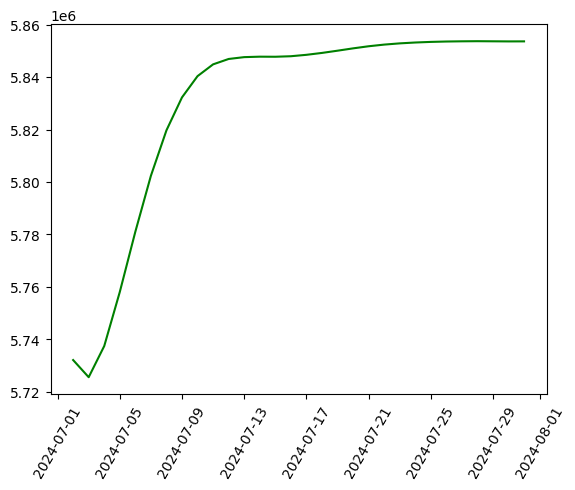

In [18]:
month = next_month_price
dates = pd.date_range(start='7/2/2024',periods=30)
plt.plot_date(dates, month, 'g')
plt.xticks(rotation=60)
plt.show()

In [19]:
import pickle
next_month_price
next_week_price
next_day_price
pickle.dump(next_day_price,open('next_day_price.pkl','wb'))
pickle.dump(next_week_price,open('next_week_price.pkl','wb'))
pickle.dump(next_month_price,open('next_month_price.pkl','wb'))

In [20]:
next_week_price[6]

5819714.396221618

In [21]:
print(type(next_week_price))

<class 'numpy.ndarray'>
